# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
%load_ext autoreload
%autoreload 2

In [2]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
#Trip mode
#1 Drive alone free; 2 Drive alone pay; 3 Shared ride 2 free; 4 Shared ride 2 pay ;
#5 Shared ride 3+ free; 6 Shared ride 3+ pay; 7 Walk; 8 Bike; 9 Walk to local transit; 
#10 Walk to premium transit; 11 Drive to local transit; 12 Drive to premium transit; 
#13 Taxi; 14 School bus

# traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
# #Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
# traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
# traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
# traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
# traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
# traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
# traveler_trips.orig_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.dest_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.loc[:,'person_type']=traveler_trips.person_id.apply(lambda x: person_type_dic[x])
# value_latearr_penalty_per_min=pd.read_csv('input/LateArrPenalty.dat',sep='\t',index_col =0)
# value_earlyarr_penalty_per_min=pd.read_csv('input/EarlyArrPenalty.dat',sep='\t',index_col =0)
# early_penalty_threshold=pd.read_csv('input/EarlyArrPenaltyThreshold.dat',sep='\t',index_col=0)
# late_penalty_threshold=pd.read_csv('input/LateArrPenaltyThreshold.dat',sep='\t',index_col=0)

# traveler_trips.loc[:,'earlyarr_penalty']=traveler_trips.apply(lambda row: value_earlyarr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'latearr_penalty']=traveler_trips.apply(lambda row: value_latearr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'early_penalty_threshold']=traveler_trips.apply(lambda row: early_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'late_penalty_threshold']=traveler_trips.apply(lambda row: late_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.to_csv('input/traveler_trip_info_improved.csv')
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv')

num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')

56 57 144


In [51]:
sorted_trips.dest_maz

20940     63
20941     71
20951     19
201092    28
201093    71
20962     39
20963     71
201094     2
326244    33
326245    31
326246    71
201095    71
201097    74
201098    71
20952     14
20953     19
201099    33
20942     55
201100    71
20943     71
371298    55
326249    60
20944     63
20945     71
326250    71
20954     71
20946     24
20947     33
138327    71
20955     78
138328    71
20957     71
20958     71
20959     71
20948     71
262946    32
262947    71
371299    71
Name: dest_maz, dtype: int64

In [60]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
single_model_runtime=60*20
drivingcost_per_mile=1
reward_mode=0
darp_solutions3=[]
cav_use_mode=1
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
for num_cav in range(1,4):
    for share_ride_factor in [1,1.25,1.5]:
        for time_window_flag in [0,1]:
    #         time_window_flag=1
            # num_cav=1
            # share_ride_factor=1.5
            # time_window_flag=0
            print('**************')
            print('Num_CAV',num_cav,share_ride_factor,time_window_flag)
            print('**************')
            darp_solutions3.extend([sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length,
                                        reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                                      cav_use_mode,time_window_flag,single_model_runtime)])

**************
Num_CAV 1 1 0
**************
18 15 1 1
2.6
16 17 2 1
4.4
18 4 2 1
4.4
start sovling problem at  2018-04-03 13:15:06.899559
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 152 rows, 80 columns and 596 nonzeros
Variable types: 16 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective -17.5485

Presolve removed 112 rows and 70 columns
Presolve time: 0.08s
Presolved: 40 rows, 10 columns, 80 nonzeros
Variable types: 10 continuous, 0 integer (0 binary)

Explored 0 nodes (0 simplex iterations) in 0.13 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: -17.5485 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.754850000000e+01

18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
start sovling problem at  2018-04-03 13:15:16.535583
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 222 rows, 120 columns and 956 nonzeros
Variable types: 20 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective 335.943

Presolve removed 222 rows and 120 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 335.944 335.943 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.359435000000e+02, best bound 3.359435000000e+02, gap 0.0000%
################################


   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 2203 rows, 1368 columns and 13596 nonzeros
Variable types: 72 continuous, 1296 integer (1296 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 3e+05]

MIP start did not produce a new incumbent solution
MIP start violates constraint PickupOnce12[12] by 1.000000000

Presolve removed 684 rows and 578 columns
Presolve time: 0.05s
Presolved: 1519 rows, 790 columns, 6415 nonzeros
Variable types: 72 continuous, 718 integer (718 binary)

Root relaxation: objective -8.819595e+01, 360 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -88.19595    0   41          -  -88.19595      -    

     0     0  -96.37497    0   34  -98.26685  -96.37497  1.93%     -    1s
     0     0  -97.75235    0   26  -98.26685  -97.75235  0.52%     -    1s
     0     0  -97.75235    0   24  -98.26685  -97.75235  0.52%     -    1s
     0     0  -97.75235    0   12  -98.26685  -97.75235  0.52%     -    1s
     0     0  -97.75235    0   28  -98.26685  -97.75235  0.52%     -    1s
     0     0  -97.75235    0   25  -98.26685  -97.75235  0.52%     -    1s
     0     0  -97.75235    0   27  -98.26685  -97.75235  0.52%     -    1s
     0     0  -97.81250    0   33  -98.26685  -97.81250  0.46%     -    1s
     0     0  -98.21314    0   33  -98.26685  -98.21314  0.05%     -    1s
     0     0  -98.21314    0   33  -98.26685  -98.21314  0.05%     -    1s
     0     2  -98.21314    0   33  -98.26685  -98.21314  0.05%     -    1s

Cutting planes:
  Gomory: 3
  Cover: 1
  MIR: 19

Explored 83 nodes (2443 simplex iterations) in 1.44 seconds
Thread count was 8 (of 8 available processors)

Solution count 4

The total reward is 114.0 
The delay cost is  0.0 
The total travel cost is  17.5485
0.0
finish solving problem at  2018-04-03 13:15:42.508235
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
start sovling problem at  2018-04-03 13:15:42.945735
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 209 rows, 120 columns and 903 nonzeros
Variable types: 20 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective -46.0565

Presolve removed 51 rows and 27 columns
Presolve time: 0.00s
Presolved: 158 rows, 93 columns, 601 nonzeros
Variable types: 20 continuous, 73 integer (73 binary)

Root relaxation: objective -1.596452e+01, 53 iterations, 0.00 seconds

    Nodes    |    Cur

     0     0  -91.34944    0   38  -97.35710  -91.34944  6.17%     -    0s
     0     0  -91.34944    0   29  -97.35710  -91.34944  6.17%     -    0s
     0     0  -91.34944    0   33  -97.35710  -91.34944  6.17%     -    0s
     0     0  -91.35058    0   39  -97.35710  -91.35058  6.17%     -    0s
     0     0  -91.36771    0   40  -97.35710  -91.36771  6.15%     -    0s
     0     0  -91.37123    0   40  -97.35710  -91.37123  6.15%     -    0s
     0     0  -93.96988    0   32  -97.35710  -93.96988  3.48%     -    0s
     0     0  -93.97411    0   35  -97.35710  -93.97411  3.47%     -    0s
     0     0  -93.97448    0   39  -97.35710  -93.97448  3.47%     -    0s
     0     0  -94.04789    0   37  -97.35710  -94.04789  3.40%     -    0s
     0     0  -94.05051    0   36  -97.35710  -94.05051  3.40%     -    0s
     0     0  -96.26906    0   28  -97.35710  -96.26906  1.12%     -    0s
     0     0  -96.26909    0   36  -97.35710  -96.26909  1.12%     -    0s
     0     0  -96.30524  


Root relaxation: objective -1.519450e+01, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -15.1945000  -15.19450  0.00%     -    0s

Explored 0 nodes (16 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: -15.1945 -17.5485 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.519450000000e+01, best bound -1.519450000000e+01, gap 0.0000%
################################
The total reward is 114.0 
The delay cost is  0.0 
The total travel cost is  15.1945
0.0
finish solving problem at  2018-04-03 13:16:00.601715
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
start sovling problem at  2018-04-03 13:16:01.054840
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max:

  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective 96.4515

Presolve removed 246 rows and 130 columns
Presolve time: 0.00s
Presolved: 12 rows, 14 columns, 64 nonzeros
Variable types: 0 continuous, 14 integer (14 binary)

Root relaxation: objective 9.880550e+01, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      98.8055000   98.80550  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 98.8055 96.4515 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.880550000000e+01, best bound 9.880550000000e+01, gap 0.0000%
################################
The total reward is 114.0 
The delay cost is  0.0 
The total travel co

18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
start sovling problem at  2018-04-03 13:16:18.648648
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 350 rows, 220 columns and 1706 nonzeros
Variable types: 20 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective -46.0565

Presolve removed 93 rows and 54 columns
Presolve time: 0.02s
Presolved: 257 rows, 166 columns, 1368 nonzeros
Variable types: 20 continuous, 146 integer (146 binary)

Root relaxation: objective -1.218650e+01, 75 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

     0     2  -90.19532    0   88          -  -90.19532      -     -    3s
*  720   314              66    -129.2656900  -93.63319  27.6%   9.6    4s
H  824   342                    -116.0106900  -93.63319  19.3%   9.4    4s
  1001   416  -99.10383   20   63 -116.01069  -95.12900  18.0%   9.1    5s
H 1008   410                    -114.6936900  -95.12900  17.1%   9.1    5s
* 1310   518              25    -113.1149400  -95.74700  15.4%   8.8    5s
* 2849   899              32    -112.2756900  -98.26012  12.5%  10.3    6s
H 5951  1159                    -111.2986900 -102.35556  8.04%  10.9    8s
H 5978  1085                    -110.5936900 -102.65057  7.18%  10.9    8s
  7957   759     cutoff   28      -110.59369 -106.06459  4.10%  10.8   10s

Cutting planes:
  Learned: 12
  Cover: 47
  MIR: 27
  Inf proof: 38
  Zero half: 29

Explored 10392 nodes (104779 simplex iterations) in 11.19 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: -110.594 -111.299 -112.276 ... -

Variable types: 20 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective 335.944

Presolve removed 337 rows and 192 columns
Presolve time: 0.00s
Presolved: 22 rows, 28 columns, 112 nonzeros
Variable types: 0 continuous, 28 integer (28 binary)

Root relaxation: objective 3.391335e+02, 11 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     339.1335000  339.13350  0.00%     -    0s

Explored 0 nodes (11 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 339.134 335.944 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.391335000000e+02, best bound 3.391335000001e+02, gap 0.0000%
####################

Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective -46.0565

Presolve removed 93 rows and 54 columns
Presolve time: 0.00s
Presolved: 257 rows, 166 columns, 1368 nonzeros
Variable types: 20 continuous, 146 integer (146 binary)

Root relaxation: objective -1.218650e+01, 75 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -12.18650    0   20  -46.05650  -12.18650  73.5%     -    0s
     0     0  -12.31950    0   20  -46.05650  -12.31950  73.3%     -    0s
     0     0  -12.61063    0   20  -46.05650  -12.61063  72.6%     -    0s
     0     0  -12.66371    0   27  -46.05650  -12.66371  72.5%     -    0s
     0     0  -12.81949    0   20  -46.05650  -12.81949  72.2%     -    0s
     0     0  -12.81949    0   20 

     0     0  -88.52887    0   90 -123.04669  -88.52887  28.1%     -    2s
     0     0  -88.52887    0   90 -123.04669  -88.52887  28.1%     -    2s
     0     0  -88.68680    0   97 -123.04669  -88.68680  27.9%     -    2s
     0     0  -88.76151    0  122 -123.04669  -88.76151  27.9%     -    2s
     0     0  -88.77195    0  118 -123.04669  -88.77195  27.9%     -    2s
     0     0  -88.77230    0  118 -123.04669  -88.77230  27.9%     -    2s
     0     0  -88.91445    0  127 -123.04669  -88.91445  27.7%     -    2s
     0     0  -88.91814    0  129 -123.04669  -88.91814  27.7%     -    2s
     0     0  -88.91814    0  129 -123.04669  -88.91814  27.7%     -    2s
     0     0  -89.03315    0  130 -123.04669  -89.03315  27.6%     -    2s
     0     0  -89.03772    0  115 -123.04669  -89.03772  27.6%     -    2s
     0     0  -89.04156    0  125 -123.04669  -89.04156  27.6%     -    2s
     0     0  -89.04156    0  125 -123.04669  -89.04156  27.6%     -    2s
     0     0  -89.16018  

Variable types: 0 continuous, 14 integer (14 binary)

Root relaxation: objective 9.880550e+01, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      98.8055000   98.80550  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.05 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 98.8055 96.4515 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.880550000000e+01, best bound 9.880550000000e+01, gap 0.0000%
################################
The total reward is 114.0 
The delay cost is  0.0 
The total travel cost is  15.1945
0.0
finish solving problem at  2018-04-03 13:17:37.515548
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
start sovling problem at  2018-04-03 13:17:37.968670
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_L

   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 503 rows, 320 columns and 2641 nonzeros
Variable types: 20 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective -46.0565

Presolve removed 380 rows and 256 columns
Presolve time: 0.00s
Presolved: 123 rows, 64 columns, 462 nonzeros
Variable types: 12 continuous, 52 integer (52 binary)

Root relaxation: objective -4.286650e+01, 25 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -42.8665000  -42.86650  0.00%     -    0s

Explored 0 nodes (25 simplex iterations) in 0.06 seconds
Thread count was

The total reward is 114.0 
The delay cost is  0.0 
The total travel cost is  15.1945
0.0
finish solving problem at  2018-04-03 13:17:56.718731
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
start sovling problem at  2018-04-03 13:17:57.187481
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 512 rows, 320 columns and 2650 nonzeros
Variable types: 20 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective 335.943

Presolve removed 484 rows and 275 columns
Presolve time: 0.00s
Presolved: 28 rows, 45 columns, 180 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)

Root relaxation: objective 3.391335e+02, 18 iterations, 0.00 seconds

    Nodes    |    Curr


Cutting planes:
  Gomory: 5
  MIR: 1
  Zero half: 9

Explored 1 nodes (406 simplex iterations) in 0.23 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: -15.1945 -15.2145 -17.5485 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.519450000000e+01, best bound -1.519450000000e+01, gap 0.0000%
################################
The total reward is 114.0 
The delay cost is  0.0 
The total travel cost is  15.1945
0.0
finish solving problem at  2018-04-03 13:18:06.303651
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
start sovling problem at  2018-04-03 13:18:06.772402
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 491 rows, 320 columns and 2509 nonzeros
Variable types: 20 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+01]


     0     0  -77.67490    0  161          -  -77.67490      -     -    1s
     0     0  -78.53217    0  149          -  -78.53217      -     -    1s
     0     0  -78.56317    0  140          -  -78.56317      -     -    1s
     0     0  -78.57322    0  141          -  -78.57322      -     -    1s
     0     0  -78.95854    0  157          -  -78.95854      -     -    1s
     0     0  -79.11081    0  160          -  -79.11081      -     -    1s
     0     0  -79.11838    0  172          -  -79.11838      -     -    1s
     0     0  -79.37372    0  163          -  -79.37372      -     -    1s
     0     0  -79.53025    0  155          -  -79.53025      -     -    1s
     0     0  -79.53975    0  130          -  -79.53975      -     -    1s
     0     0  -79.53975    0  130          -  -79.53975      -     -    1s
     0     0  -79.61373    0  162          -  -79.61373      -     -    1s
     0     0  -79.69663    0  174          -  -79.69663      -     -    1s
     0     0  -79.73476  

* 6297   936              44     -84.8888500  -82.14344  3.23%  12.7   15s
* 7096  1176              44     -84.8648500  -82.23816  3.10%  12.7   16s
* 7605  1107              46     -84.3528500  -82.27741  2.46%  13.0   16s
* 7973  1036              39     -84.2888500  -82.35494  2.29%  13.2   16s
H 8855   716                     -83.8913500  -82.65414  1.47%  13.5   17s
* 8857   709              43     -83.8768500  -82.65414  1.46%  13.5   17s

Cutting planes:
  Learned: 12
  Gomory: 11
  MIR: 24
  Flow cover: 39
  Inf proof: 16
  Zero half: 34

Explored 10080 nodes (133653 simplex iterations) in 18.58 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: -83.8769 -83.8914 -84.2888 ... -103.985

Optimal solution found (tolerance 1.00e-04)
Best objective -8.387685000000e+01, best bound -8.387685000000e+01, gap 0.0000%
################################
The total reward is 483.0 
The delay cost is  0.058000000000006935 
The total travel cost is  83.81885
0.0
finish s

16 17 2 1
4.4
18 4 2 1
4.4
start sovling problem at  2018-04-03 13:20:10.122974
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 341 rows, 208 columns and 1551 nonzeros
Variable types: 16 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective -17.5485

Presolve removed 113 rows and 63 columns
Presolve time: 0.02s
Presolved: 228 rows, 145 columns, 1151 nonzeros
Variable types: 16 continuous, 129 integer (129 binary)

Root relaxation: objective -5.211750e+00, 62 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -5.21175    0   27  

################################
The total reward is 382.0 
The delay cost is  1.0859999999999608 
The total travel cost is  30.689
0.21900000000002162
finish solving problem at  2018-04-03 13:20:11.701107
18 1 3 1
5.9
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
1 17 4 1
6.5
20 18 4 1
1.9
19 17 4 1
1.6
5 3 4 1
0.6
4 4 4 1
2.9
18 8 5 1
1.6
18 13 5 1
11.2
9 17 5 1
2.0
14 17 5 1
4.8
18 13 6 1
11.2
18 14 6 1
2.2
18 15 6 1
2.6
16 17 6 1
3.0
start sovling problem at  2018-04-03 13:20:14.951120
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 6057 rows, 3960 columns and 39964 nonzeros
Variable types: 72 continuous, 3888 integer (3888 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 3e+05]

MIP start did not produce a new incumbent solution
MIP

     0     0  -75.36410    0   53          -  -75.36410      -     -    1s
     0     0  -75.36410    0   58          -  -75.36410      -     -    1s
     0     0  -75.37294    0   57          -  -75.37294      -     -    1s
     0     0  -75.37294    0   65          -  -75.37294      -     -    1s
     0     0  -75.37415    0   68          -  -75.37415      -     -    1s
     0     0  -75.38441    0   64          -  -75.38441      -     -    1s
     0     0  -75.38441    0   66          -  -75.38441      -     -    1s
     0     0  -75.38446    0   67          -  -75.38446      -     -    1s
     0     0  -75.39475    0   73          -  -75.39475      -     -    1s
     0     0  -75.39475    0   75          -  -75.39475      -     -    1s
     0     0  -75.40551    0   71          -  -75.40551      -     -    1s
     0     0  -75.40551    0   66          -  -75.40551      -     -    1s
     0     0  -75.40790    0   96          -  -75.40790      -     -    1s
H    0     0             

Optimize a model with 4252 rows, 2760 columns and 26113 nonzeros
Variable types: 60 continuous, 2700 integer (2700 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 3e+05]

Loaded MIP start with objective 331.011

Presolve removed 4112 rows and 2097 columns
Presolve time: 0.12s
Presolved: 140 rows, 663 columns, 2898 nonzeros
Variable types: 0 continuous, 663 integer (663 binary)

Root relaxation: objective 3.991539e+02, 232 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  399.15390    0   37  331.01115  399.15390  20.6%     -    0s
H    0     0                     398.9414000  399.15390  0.05%     -    0s
     0     0  399.15390    0   36  398.94140  399.15390  0.05%     -    0s
     0     0     cutoff    0       398.94140  398.94140  0.

In [45]:
Vehicular_Skim.loc[18,15,1,1]

Cost    0.00
Dist    2.91
Time    2.60
Vot     1.00
Name: (18, 15, 1, 1), dtype: float64

In [53]:
zz1=solution['route_info']

In [58]:
zz1.dest_zone=zz1.dest_zone.apply(lambda x: int(x))

18 15 1 1
2.6
16 17 2 1
4.4
18 4 2 1
4.4
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
18 1 3 1
5.9
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
1 17 4 1
6.5
20 18 4 1
1.9
19 17 4 1
1.6
5 3 4 1
0.6
4 4 4 1
2.9
18 8 5 1
1.6
18 13 5 1
11.2
9 17 5 1
2.0
14 17 5 1
4.8
18 13 6 1
11.2
18 14 6 1
2.2
18 15 6 1
2.6
16 17 6 1
3.0
15 17 7 1
4.5
5 17 7 1
4.9
18 5 7 1
2.1
6 8 7 1
3.2
18 17 7 1
2.4
18 19 8 1
0.5
18 17 8 1
2.4
20 17 8 1
4.0
18 17 8 1
2.4
18 17 8 1
2.4
9 17 8 1
2.0
18 7 8 1
9.1
8 17 9 1
3.3
14 17 10 1
5.1
18 15 1 1
2.6
16 17 2 1
4.4
18 4 2 1
4.4
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
18 1 3 1
5.9
1 17 4 1
6.5
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
18 1 4 1
5.9
1 17 4 1
6.5
18 19 4 1
0.5
20 18 4 1
1.9
19 17 4 1
1.6
18 4 4 1
4.4
5 3 4 1
0.6
4 4 4 1
2.9
5 17 5 1
4.9
18 8 5 1
1.6
9 8 5 1
3.6
9 17 5 1
2.0
18 17 5 1
2.5
18 13 5 1
11.2
14 13 5 1
3.9
14 17 5 1
4.8
18 13 6 1
11.2
14 17 6 1
4.8
18 15 6 1
2.6
16 17 6 1
3.0
18 17 10 1
2.5
18 14 6 1
2.2
15 17 7 1
4.5
18 4 7 1
4.3


18 4 7 1
4.3
5 17 7 1
4.9
18 5 7 1
2.1
6 8 7 1
3.2
9 17 7 1
2.0
18 17 7 1
2.4
18 17 8 1
2.4
18 17 8 1
2.4
18 17 8 1
2.4
18 19 8 1
0.5
20 19 8 1
1.0
20 17 8 1
4.0
18 17 8 1
2.4
18 17 8 1
2.4
18 8 8 1
1.4
9 17 8 1
2.0
18 7 8 1
9.1
8 17 9 1
3.3
18 13 10 1
11.2
14 17 10 1
5.1
9 17 4 1
2.0
1 7 4 1
3.2
18 1 4 1
5.9
18 19 4 1
0.5
18 4 4 1
4.4
5 17 5 1
4.9
9 8 5 1
3.6
18 17 5 1
2.5
14 13 5 1
3.9
14 17 6 1
4.8
18 17 10 1
2.5
18 4 7 1
4.3
9 17 7 1
2.0
18 17 8 1
2.4
18 17 8 1
2.4
20 19 8 1
1.0
18 8 8 1
1.4
18 13 10 1
11.2
18 15 1 1
2.6
16 17 2 1
4.4
18 4 2 1
4.4
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
18 1 3 1
5.9
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
1 17 4 1
6.5
20 18 4 1
1.9
19 17 4 1
1.6
5 3 4 1
0.6
4 4 4 1
2.9
18 8 5 1
1.6
18 13 5 1
11.2
9 17 5 1
2.0
14 17 5 1
4.8
18 13 6 1
11.2
18 14 6 1
2.2
18 15 6 1
2.6
16 17 6 1
3.0
15 17 7 1
4.5
5 17 7 1
4.9
18 5 7 1
2.1
6 8 7 1
3.2
18 17 7 1
2.4
18 19 8 1
0.5
18 17 8 1
2.4
20 17 8 1
4.0
18 17 8 1
2.4
18 17 8 1
2.4
9 17 8 1
2.0
18 7 8 1
9

18 15 1 1
2.6
16 17 2 1
4.4
18 4 2 1
4.4
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
18 1 3 1
5.9
1 17 4 1
6.5
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
18 1 4 1
5.9
1 17 4 1
6.5
18 19 4 1
0.5
20 18 4 1
1.9
19 17 4 1
1.6
18 4 4 1
4.4
5 3 4 1
0.6
4 4 4 1
2.9
5 17 5 1
4.9
18 8 5 1
1.6
9 17 5 1
2.0
18 13 5 1
11.2
14 13 5 1
3.9
14 17 5 1
4.8
18 13 6 1
11.2
14 17 6 1
4.8
18 14 6 1
2.2
15 17 6 1
4.5
18 15 6 1
2.6
16 17 6 1
3.0
15 17 7 1
4.5
18 4 7 1
4.3
5 17 7 1
4.9
18 5 7 1
2.1
6 8 7 1
3.2
9 17 7 1
2.0
18 19 8 1
0.5
20 19 8 1
1.0
20 17 8 1
4.0
18 17 8 1
2.4
18 17 8 1
2.4
18 8 8 1
1.4
9 17 8 1
2.0
18 7 8 1
9.1
8 17 9 1
3.3
18 13 10 1
11.2
14 17 10 1
5.1
1 17 4 1
6.5
18 1 4 1
5.9
18 19 4 1
0.5
18 4 4 1
4.4
5 17 5 1
4.9
9 17 5 1
2.0
14 13 5 1
3.9
14 17 6 1
4.8
15 17 6 1
4.5
18 4 7 1
4.3
9 17 7 1
2.0
20 19 8 1
1.0
18 8 8 1
1.4
18 13 10 1
11.2
18 15 1 1
2.6
16 17 2 1
4.4
18 4 2 1
4.4
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
18 1 3 1
5.9
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3


18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
1 17 4 1
6.5
20 18 4 1
1.9
19 17 4 1
1.6
5 3 4 1
0.6
4 4 4 1
2.9
18 8 5 1
1.6
18 13 5 1
11.2
9 17 5 1
2.0
14 17 5 1
4.8
18 13 6 1
11.2
18 14 6 1
2.2
18 15 6 1
2.6
16 17 6 1
3.0
15 17 7 1
4.5
5 17 7 1
4.9
18 5 7 1
2.1
6 8 7 1
3.2
18 17 7 1
2.4
18 19 8 1
0.5
18 17 8 1
2.4
20 17 8 1
4.0
18 17 8 1
2.4
18 17 8 1
2.4
9 17 8 1
2.0
18 7 8 1
9.1
8 17 9 1
3.3
14 17 10 1
5.1
18 15 1 1
2.6
16 17 2 1
4.4
18 4 2 1
4.4
18 17 3 1
2.5
18 9 3 1
13.1
10 6 3 1
0.9
7 17 3 1
5.9
7 17 3 1
5.9
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
18 17 4 1
2.5
18 8 5 1
1.6
9 17 5 1
2.0
18 13 5 1
11.2
14 13 5 1
3.9
14 17 5 1
4.8
18 17 6 1
2.4
18 15 6 1
2.6
16 17 6 1
3.0
18 17 10 1
2.5
18 14 6 1
2.2
18 1 3 1
5.9
1 1 4 1
0.3
1 17 4 1
6.5
18 19 4 1
0.5
20 18 4 1
1.9
19 17 4 1
1.6
18 4 4 1
4.4
5 3 4 1
0.6
4 4 4 1
2.9
5 8 5 1
2.9
9 17 5 1
2.0
18 17 5 1
2.5
18 13 6 1
11.2
15 17 7 1
4.5
18 4 7 1
4.3
5 17 7 1
4.9
18 5 7 1
2.1
6 8 7 1
3.2
9 17 7 1
2.0
18 17 7 1
2.4
18 17 8 1
2.4
18 17 8 1
2.4
18 1

18 5 7 1
2.1
6 8 7 1
3.2
9 17 7 1
2.0
18 17 8 1
2.4
18 8 8 1
1.4
9 17 8 1
2.0
18 7 8 1
9.1
8 17 9 1
3.3
1 1 4 1
0.3
18 19 4 1
0.5
18 17 4 1
2.5
9 17 5 1
2.0
14 13 5 1
3.9
14 17 6 1
4.8
18 4 4 1
4.4
5 8 5 1
2.9
18 17 5 1
2.5
18 17 7 1
2.4
18 19 8 1
0.5
18 13 8 1
11.0
18 17 7 1
2.4
9 17 7 1
2.0
18 8 8 1
1.4
18 15 1 1
2.6
16 17 2 1
4.4
18 4 2 1
4.4
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
18 1 3 1
5.9
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
1 17 4 1
6.5
20 18 4 1
1.9
19 17 4 1
1.6
5 3 4 1
0.6
4 4 4 1
2.9
18 8 5 1
1.6
18 13 5 1
11.2
9 17 5 1
2.0
14 17 5 1
4.8
18 13 6 1
11.2
18 14 6 1
2.2
18 15 6 1
2.6
16 17 6 1
3.0
15 17 7 1
4.5
5 17 7 1
4.9
18 5 7 1
2.1
6 8 7 1
3.2
18 17 7 1
2.4
18 19 8 1
0.5
18 17 8 1
2.4
20 17 8 1
4.0
18 17 8 1
2.4
18 17 8 1
2.4
9 17 8 1
2.0
18 7 8 1
9.1
8 17 9 1
3.3
14 17 10 1
5.1
18 4 2 1
4.4
18 15 1 1
2.6
16 17 2 1
4.4
18 9 3 1
13.1
10 17 3 1
7.0
18 6 3 1
12.2
7 17 3 1
5.9
18 1 3 1
5.9
1 1 4 1
0.3
1 17 4 1
6.5
18 19 4 1
0.5
20 18 4 1
1.9
19 17 4 1
1.6
18 

18 13 5 1
11.2
14 13 5 1
3.9
14 17 5 1
4.8
18 13 6 1
11.2
5 3 4 1
0.6
4 4 4 1
2.9
14 17 10 1
5.1
5 17 7 1
4.9
18 5 7 1
2.1
6 8 7 1
3.2
9 17 7 1
2.0
18 17 8 1
2.4
18 19 8 1
0.5
20 17 8 1
4.0
18 17 8 1
2.4
18 17 8 1
2.4
18 8 8 1
1.4
9 17 8 1
2.0
18 7 8 1
9.1
8 17 9 1
3.3
15 17 7 1
4.5
18 17 7 1
2.4
18 17 7 1
2.4
18 19 8 1
0.5
1 1 4 1
0.3
18 19 4 1
0.5
18 8 4 1
1.7
18 17 5 1
2.5
18 17 10 1
2.5
18 17 4 1
2.5
9 17 5 1
2.0
14 13 5 1
3.9
9 17 7 1
2.0
18 19 8 1
0.5
18 8 8 1
1.4
18 17 7 1
2.4
18 15 1 1
2.6
16 17 2 1
4.4
18 4 2 1
4.4
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
18 1 3 1
5.9
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
1 17 4 1
6.5
20 18 4 1
1.9
19 17 4 1
1.6
5 3 4 1
0.6
4 4 4 1
2.9
18 8 5 1
1.6
18 13 5 1
11.2
9 17 5 1
2.0
14 17 5 1
4.8
18 13 6 1
11.2
18 14 6 1
2.2
18 15 6 1
2.6
16 17 6 1
3.0
15 17 7 1
4.5
5 17 7 1
4.9
18 5 7 1
2.1
6 8 7 1
3.2
18 17 7 1
2.4
18 19 8 1
0.5
18 17 8 1
2.4
20 17 8 1
4.0
18 17 8 1
2.4
18 17 8 1
2.4
9 17 8 1
2.0
18 7 8 1
9.1
8 17 9 1
3.3
14 17 10 1
5

20 18 4 1
1.9
19 17 4 1
1.6
18 8 4 1
1.7
9 17 5 1
2.0
18 17 5 1
2.5
18 13 6 1
11.2
14 17 6 1
4.8
18 14 6 1
2.2
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
18 17 4 1
2.5
18 8 5 1
1.6
9 17 5 1
2.0
18 13 5 1
11.2
14 13 5 1
3.9
14 17 5 1
4.8
18 17 6 1
2.4
18 15 6 1
2.6
16 17 6 1
3.0
5 3 4 1
0.6
4 4 4 1
2.9
5 17 7 1
4.9
18 17 7 1
2.4
18 17 7 1
2.4
18 19 8 1
0.5
20 17 8 1
4.0
18 17 8 1
2.4
18 17 8 1
2.4
18 17 8 1
2.4
18 7 8 1
9.1
8 17 9 1
3.3
14 17 10 1
5.1
15 17 7 1
4.5
18 17 7 1
2.4
18 5 7 1
2.1
6 8 7 1
3.2
9 17 7 1
2.0
18 17 8 1
2.4
18 8 8 1
1.4
9 17 8 1
2.0
1 1 4 1
0.3
18 19 4 1
0.5
18 8 4 1
1.7
18 17 5 1
2.5
14 17 6 1
4.8
18 17 4 1
2.5
9 17 5 1
2.0
14 13 5 1
3.9
18 17 6 1
2.4
18 17 7 1
2.4
18 19 8 1
0.5
18 17 8 1
2.4
18 17 7 1
2.4
9 17 7 1
2.0
18 8 8 1
1.4
18 15 1 1
2.6
16 17 2 1
4.4
18 4 2 1
4.4
18 6 3 1
12.2
7 17 3 1
5.9
18 9 3 1
13.1
10 17 3 1
7.0
18 1 3 1
5.9
18 8 4 1
1.7
9 7 4 1
2.1
8 17 4 1
3.3
1 17 4 1
6.5
20 18 4 1
1.9
19 17 4 1
1.6
5 3 4 1
0.6
4 4 4 1
2.9
18 8 5 1
1.6
18 13 5 1
11.2


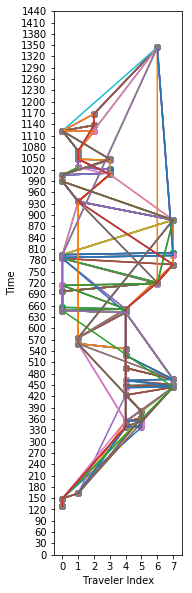

In [61]:
analyzed_results3=pd.DataFrame()
for solution in darp_solutions3:
    analyzed_results3=analyzed_results3.append(pod.analysis_result(solution,sorted_trips,Vehicular_Skim,superzone_map),ignore_index=True)

In [ ]:
analyzed_results3.transpose().to_csv('Output/hh_level_result3.csv')

In [10]:
analyzed_results.transpose().to_csv('hh_level_result.csv')

In [12]:
analyzed_results.transpose()

,0,1,2,3,4,5,6,7,8
Total_early_time,-120.980000,-95.980000,-168.830000,-120.980000,-68.180000,-81.350000,-90.980000,-5.000000,-98.180000
cav_use_mode,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
drivingcost_per_mile,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
num_cav,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000
num_cav_trips,99.000000,102.000000,103.000000,99.000000,99.000000,99.000000,93.000000,97.000000,96.000000
num_convention car trips,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
num_delayed_trips,4.000000,4.000000,5.000000,4.000000,2.000000,7.000000,2.000000,4.000000,7.000000
num_early_trips,12.000000,14.000000,14.000000,12.000000,6.000000,11.000000,8.000000,2.000000,10.000000
num_occupied_trips,63.000000,68.000000,72.000000,63.000000,66.000000,72.000000,63.000000,67.000000,69.000000
num_pickup_trips,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,64.000000,64.000000


### Basic Statistics

In [ ]:
traveler_trips.head()

In [ ]:
traveler_trips.columns

In [ ]:
#Num of household
print('Number of household: \t',len(traveler_trips.hh_id.unique()))
print('Number of traveler: \t',len(traveler_trips.person_id.unique()))
print('Number of trips: \t',len(traveler_trips))
print('Number of indiv trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==0]))
print('Number of joint trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==1]))

In [ ]:
traveler_trips['orig_purpose'].value_counts().plot(kind='bar',title='Histogram of Origin Purpose')

In [ ]:
traveler_trips.tripmode.hist()

In [ ]:
traveler_trips.num_trips.hist()
plt.pyplot.title('Histogram of trip per person')

In [ ]:
traveler_trips.groupby('hh_id')['num_trips'].count().hist()
plt.pyplot.title('Histogram of trip per household')

### Sample Household
Select household 2287301 for intial analysis

In [ ]:
target_hh_id=2287301
people_in_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

#### Solve with heuristic

## Estimate travel time and cost

## Solve the optimization with Gurobi

In [ ]:
drivingcost_per_mile=1
transit_fare=2
transit_asc=2

##### Try to solve the problem for a single household

#### Solve with exact method

In [ ]:
print('prepare input for dial n ride model at ',datetime.datetime.now())
output_flag=1
target_hh_id=2287301
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
# R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
R=estimate_trip_reward(hh_num_trips,sorted_trips,Vehicular_Skim)
print('start sovling problem at ',datetime.datetime.now())
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode=)
print('finish solving problem at ',datetime.datetime.now())
route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
print('extract solution at',datetime.datetime.now())
route_info.to_csv('route_info_yingjie.csv')

In [ ]:
T_sol=np.ones(2*hh_num_trips+2)
for i in range(2*hh_num_trips+2):
#     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
    T_sol[i]=T[i].x
schedule_deviation=T_sol-expected_arrival_time
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,schedule_deviation)

#### Solve with the schedule partition heuristic

In [ ]:
def analysis_result(route_info,sorted_trips,Vehicular_Skim,schedule_deviation):
    print('Number of CAV Trips',len(route_info))
    print('Number of Occupied trips',len(route_info.loc[route_info.person_id>0]))
    print('Number of unoccupied trips',len(route_info.loc[route_info.person_id==0]))
    print('Number of pickup trips',len(route_info.loc[route_info.orig_node_index<=len(sorted_trips)]))
    print('Number of shared trips',len(route_info.loc[(route_info.orig_node_index<=len(sorted_trips)) &(route_info.dest_node_index<=len(sorted_trips))]))
    print('Number of convention car trips',len(sorted_trips.loc[sorted_trips.tripmode<=6]))
    # Compare the VHT between convention vehicle and CAV
    
    total_convention_vehicle_driving_time=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row:estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_driving_time=route_info.apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_unoccupied_driving_time=route_info.loc[route_info.person_id==0].apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    print('Convention car trips VHT: \t',total_convention_vehicle_driving_time/60,
          '\nAV driving time: \t',total_AV_driving_time/60,
          '\nAV unoccupied driving_time: \t',total_AV_unoccupied_driving_time/60)
    # Compare the VMT between convention vehicle and CAV
    total_convention_vehicle_driving_distance=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row: estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    total_AV_driving_distance=route_info.apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1) ,axis=1).sum()
    total_AV_unoccupied_driving_distance=route_info.loc[route_info.person_id==0].apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    print('Convention VMT: \t',total_convention_vehicle_driving_distance,
          '\nAV driving distance: \t',total_AV_driving_distance,
          '\nAV unoccupied driving_distance: \t',total_AV_unoccupied_driving_distance)
    print('Number of delayed trips\t',sum(1 for i in schedule_deviation if i >1))
    print('Number of early trips\t',sum(1 for i in schedule_deviation if i <-1))
    print('Total delayed time\t',sum(i for i in schedule_deviation if i >0))
    print('Total_early_time\t',sum(i for i in schedule_deviation if i <0))
    plt.pyplot.figure(1,figsize=[2.3,10])
    plot_route_info_schedule(route_info,sorted_trips)
    return

In [ ]:
def plot_route_info_schedule(route_info,sorted_trips):
#     z=traveler_trips[traveler_trips.hh_id==route_info.hh_id[0]]
    sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
    hh_num_trips=len(sorted_trips)
    person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
    person_id_and_inhouse_p_id_map[0]=-1
    route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
    
    plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                    route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
#     plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) & (route_info.dest_node_index<1+hh_num_trips),'p_id'],
#                     route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) &(route_info.dest_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.xlabel('Traveler Index')
    plt.pyplot.ylabel('Time')
    plt.pyplot.grid()
    plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
    plt.pyplot.yticks(np.arange(0,1441,30))
#     plt.pyplot.title(title)
    return 

#### All trips take CAV

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
share_ride_factor=2
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_partition,all_trips_schedule_deviation=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation)

#### Strict time window

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=2
time_window_flag=1
num_poav=2
single_model_runtime=60*5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_stricttw,all_trips_schedule_deviation_stricttw=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_stricttw,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_stricttw)

##### Only car trips take CAV

In [ ]:
len(sorted_car_trips)

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
sorted_car_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_car_trips.shape[0]
sorted_car_trips["hh_index"]=(range(hh_num_trips))
car_trips_route_info_partition,car_trips_schedule_deviation=solve_with_schedule_partition(sorted_car_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(car_trips_route_info_partition,sorted_car_trips,Vehicular_Skim,car_trips_schedule_deviation)

#### Ban Shared Rides

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_ban_sharerides,all_trips_schedule_deviation_ban_sharerides=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_ban_sharerides,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_ban_sharerides)

#### Share ride factor 1.25

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
share_ride_factor=1.25
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_sharerides125,all_trips_schedule_deviation_sharerides125=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_sharerides125,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_sharerides125)

In [ ]:
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(142)
plot_route_info_schedule(car_trips_route_info_partition,sorted_car_trips)
plt.pyplot.subplot(143)
plot_route_info_schedule(all_trips_route_info_partition,sorted_trips)
plt.pyplot.subplot(144)
plot_route_info_schedule(all_trips_route_info_ban_sharerides,sorted_trips)

#### Probability Mode Choice

In [ ]:
drivingcost_per_mile=1
transit_fare=1.4
transit_asc=2

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=1
share_ride_factor=1.5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
mode_choice_route_info,mode_choice_schedule_deviation=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
sorted_trips=compare_mode_utlity(sorted_trips)

In [ ]:
min_length=15
max_length=20
run_mode=0
share_ride_factor=1.5
force_serve_factor=1
car_sorted_trips=sorted_trips.loc[sorted_trips.expected_mode=='Car']
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
car_only_mode_choice_route_info,car_only_mode_choice_schedule_deviation=solve_with_schedule_partition(car_sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)
force_serve_factor=0

In [ ]:
sorted_trips[['transit_time','transit_walk_time','car_time','toll_cost','car_dist','transit_utility','car_utility','expected_mode','actual_mode','value_of_time']]

In [ ]:
# sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]
# sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
# route_info=pd.DataFrame()

# total_previous_sub_trips_length=0
# total_tailing_sub_trips_length=0
# schedule_deviation=[]
# x_list=[]
# for sub_sorted_trip in sub_sorted_trips:

#     num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
#     # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
#     R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
#     print('start sovling problem at ',datetime.datetime.now())
#     m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag)
#     x_list.extend([x])
#     print('finish solving problem at ',datetime.datetime.now())
#     sub_route_info=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
#     total_tailing_sub_trips_length=len(sorted_trips)-total_previous_sub_trips_length-len(sub_sorted_trip)
#     sub_route_info['orig_node_index']=sub_route_info.orig_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     sub_route_info['dest_node_index']=sub_route_info.dest_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     total_previous_sub_trips_length=total_previous_sub_trips_length+len(sub_sorted_trip)
#     route_info=route_info.append(sub_route_info)
# #         for index, row in route_info.iterrows():
# #             print(route_info.dest_expected_arrival_time,'\t',row.dest_arrival_time,'\t',row.start_time,'\t',T[row.dest_node_index].x)
# #         #Estimate the delay and early arrival
# T_sol=np.ones(2*hh_num_trips+2)
# for i in range(2*hh_num_trips+2):
# #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
#     T_sol[i]=T[i].x
#     print(T_sol[i],expected_arrival_time[i])
# schedule_deviation.extend(T_sol-expected_arrival_time)

In [ ]:
sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
hh_num_trips=len(sorted_trips)
person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
person_id_and_inhouse_p_id_map[0]=-1
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plot_route_info_schedule(car_only_mode_choice_route_info,car_sorted_trips)
z1=[sorted_trips.iloc[i-1].p_id for i in temp3]
z2=[sorted_trips.iloc[i-1].starttime for i in temp3]
print(z1,z2)
plt.pyplot.scatter(z1,z2)

In [ ]:
analysis_result(mode_choice_route_info,sorted_trips,Vehicular_Skim,mode_choice_schedule_deviation)

In [ ]:
sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
#     route_info=pd.DataFrame()
for sub_sorted_trip in sub_sorted_trips:
#     sub_sorted_trip=sub_sorted_trips[1]
    num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
    # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
    # R=np.ones(hh_num_trips+1)*10
    R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
    print('start sovling problem at ',datetime.datetime.now())
    m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode)
    print('finish solving problem at ',datetime.datetime.now())
    sub_route_info_temp=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
    
    T_sol=np.ones(2*hh_num_trips+2)
    for i in range(2*hh_num_trips+2):
    #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
        T_sol[i]=T[i].x
    schedule_deviation.extend(T_sol-expected_arrival_time)
    analysis_result(sub_route_info_temp,sub_sorted_trips,Vehicular_Skim,schedule_deviation)

In [ ]:
analysis_result(sub_route_info,sub_sorted_trip,Vehicular_Skim,schedule_deviation)

In [ ]:
z=traveler_trips[traveler_trips.hh_id==2287301]
z.loc[:,'p_id']=z.groupby(['person_id']).ngroup()
z.loc[:,'expected_arrival']=z.starttime+z.travel_time
person_id_and_inhouse_p_id_map=dict(zip(z.person_id,z.p_id))
person_id_and_inhouse_p_id_map[0]=-1
sorted_trips.loc[:,'p_id']=sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info_partition['p_id']=route_info_partition.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])

plt.pyplot.figure(1,figsize=[21,14])
plt.pyplot.subplot(131)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)

# plt.pyplot.scatter(z.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),z.starttime,marker='o',facecolors='none', edgecolors='r')

# plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
#                 route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'start_time']
#                )
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(132)
# plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
# plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
#                    sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
#                    c='r')

plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(133)
plt.pyplot.scatter(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])

plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))

In [ ]:
sorted_trips=target_hh.sort_values("starttime")
sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]

In [ ]:
plot_route_info_schedule(sub_route_info,traveler_trips)

In [ ]:
sub_route_info.groupby('person_id').count()

In [ ]:
sub_sorted_trip.groupby('person_id').count()

In [ ]:
sub_route_info

##### Solve the problem for all households

In [ ]:
route_infos=get_route_info_allhh(traveler_trips,0)

In [ ]:
route_infos.to_csv('Output/route_infos_fullconversion_lessthan40triphh.csv')

In [ ]:
route_infos.to_csv('Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_fullconversion.csv')
route_infos_part_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption.head()

#### Compare the new route with the old one

In [ ]:
initial_trips=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
len1=[]
len2=[]
origin_num_car_trips=[]
num_empty_car_trips=[]
num_initial_car_trips=0
for name, group in route_infos_full_adoption.groupby(['hh_id']):
    num_initial_car_trips=num_initial_car_trips+len(initial_trips.loc[(initial_trips.hh_id==name) & ((initial_trips.tripmode<=6) | (initial_trips.tripmode==13))])
#     len1.extend([len(group)])
#     len2.extend([len(initial_trips.loc[initial_trips.hh_id==name])])
#     origin_num_car_trips.extend([len(initial_trips.loc[(initial_trips.tripmode<=6) | (initial_trips.tripmode==13)])])
#     num_empty_car_trips.extend([len(group[group.person_id==0])])

In [ ]:
zz=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime']).groupby('hh_id').count() 

In [ ]:
zz1=traveler_trips.groupby('hh_id').count() 

In [ ]:
traveler_trips.columns

In [ ]:
zz[zz.person_id>30].person_id.sum()

In [ ]:
print('The new route plan has ',sum(len1),' trips')
print('The origin trip plan has ',sum(len2),' trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode<=6]),'car trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode==13]),'taxi trips')
print('The new route plan has',sum(num_empty_car_trips),'empty car trips')

### Route result analysis

##### Estimate how many trips are satisfied

In [ ]:
route_infos.head()

In [ ]:
def calculate_num_pick_up_trips(route_infos,traveler_trips):
    total_num_pickup_trip=0
    total_num_joint_trip=0
    for target_hh_id in route_infos.hh_id.unique():
        target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
        #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
        sorted_trips=target_hh.sort_values("starttime")
        hh_num_trips=len(sorted_trips)
        total_num_pickup_trip=total_num_pickup_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)])
        total_num_joint_trip=total_num_joint_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)& (route_infos.dest_node_index<hh_num_trips)])
    return total_num_pickup_trip,total_num_joint_trip
    #     print(target_hh_id)

In [ ]:
# Calculate the number of trips with/without passenger
full_adoption_num_pickup,full_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_full_adoption,traveler_trips)
full_adoption_empty_trips=len(route_infos_full_adoption.loc[route_infos_full_adoption.person_id==0])
partial_adoption_num_pickup,partial_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_part_adoption,traveler_trips)
partial_adoption_empty_trips=len(route_infos_part_adoption.loc[route_infos_part_adoption.person_id==0])

In [ ]:
full_adoption_num_pickup

In [ ]:
partial_adoption_num_pickup

In [ ]:
full_adoption_extra_joint

In [ ]:
len(route_infos_part_adoption)

In [ ]:
partial_adoption_extra_joint

In [ ]:
print('The full conversion plan pickup ',full_adoption_num_pickup,'trips (',round(full_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The full conversion plan incurs ', full_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is', full_adoption_empty_trips/full_adoption_num_pickup)
print('The partial conversion plan pickup ',partial_adoption_num_pickup,'trips (',round(partial_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The partial conversion plan incurs ', partial_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is' ,partial_adoption_empty_trips/partial_adoption_num_pickup)

In [ ]:
route_infos_full_adoption.columns

In [ ]:
z=route_infos_full_adoption.groupby('hh_id').apply(lambda x: (x==0).sum())

In [ ]:
z['num_hh_member']=traveler_trips.groupby('hh_id')['person_id'].nunique()

In [ ]:
def plot_num_trips_by_timeinterval(route_infos):
    route_infos['occupy_flag']=['Occupied' if x >0 else 'Empty' for x in route_infos['person_id']]
    route_infos['start_time_interval']=[math.floor(x/36) for x in route_infos['start_time']]
    z=route_infos.groupby(['start_time_interval', 'occupy_flag'])['start_time'].count().unstack('occupy_flag').fillna(0)
#     fig, axes = plt.pyplot.subplots(nrows=1 ,ncols=1,figsize=(16,6))
    
    z[['Occupied','Empty']].plot(kind='bar',stacked=True,figsize=(16,6))
    z['Empty_percentage']=z['Empty']/(z['Occupied']+z['Empty'])
#     z['Empty_percentage'].plot(kind='bar',ax=axes[1])
    return z

In [ ]:
z1=plot_num_trips_by_timeinterval(route_infos_full_adoption)

In [ ]:
z2=plot_num_trips_by_timeinterval(route_infos_part_adoption)

In [ ]:
fig = plt.pyplot.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
z1.Empty_percentage.plot(kind='bar',ax=ax,color='r',position=0)
z2.Empty_percentage.plot(kind='bar',ax=ax2,color='blue',position=1)

#### Write the route to DYNASMART input file vehicle.dat

In [ ]:
vehicledat_filepath='Output/vehicle_partconversion.dat'
path_filepath='Output/path_partconversion.dat'

In [ ]:
def read_vehicledat(vehicledat_filepath):
    '''
    This function read all sort of vehicledat file. It returns a dataframe vehicle_info that 
    contains all the information. Each row is corresponding to one vehicle in the vehicle.dat. 
    
    '''
    feature_list=['counter','iutmp','idtmp','StartTime','ivcltmp','ivcl2tmp','ihovtmp','veh_pathnodenum','NonrepetitiveCarNumTrip','infotmp','ribftmp','comptmp','TAZMap','value_of_time','value']
    i=0 #line number of vehicle.dat
    j=0 #line number of vehicle_info
    dest_chain=[]
    activity_chain=[]
    with open(vehicledat_filepath) as f: #Open the file
        for line in f:
            if i ==0: #Read the num_vehicle and max number of unit from the first line
                num_vehicle=int(line.split()[0])
                max_num_trips=int(line.split()[1])
                vehicle_info = pd.DataFrame(0,index=np.arange(num_vehicle), columns=feature_list)
            elif i >1:
                if (len(line)>30): #If the line is the first line of a vehicle, read the general information about vehicle
                    vehicle_info.iloc[j]=[float(k) for k in line.split()]
                    dest_chain.append([])
                    activity_chain.append([])
                    j=j+1
                else:
                    taz_temp,activity_time=line.split()
                    dest_chain[j-1].extend([taz_temp])
                    activity_chain[j-1].extend([activity_time])
                    
            i=i+1
        vehicle_info['dest_chain']=dest_chain
        vehicle_info['activity_time']=activity_chain
    return vehicle_info
def read_pathdat(pathdat_filepath):
    path_bank=[]
    with open(pathdat_filepath) as f:
        for line in f:
            path_bank.append([int(i) for i in line.split()])
    return path_bank

In [ ]:
def read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath):
    feature_list=['counter','iutmp','idtmp','StartTime','ivcltmp','ivcl2tmp','ihovtmp','veh_pathnodenum',
                  'NonrepetitiveCarNumTrip','infotmp','ribftmp','comptmp','TAZMap','value_of_time','value']
    i=0 #line number of vehicle.dat
    j=0 #line number of vehicle_info
    dest_chain=[]
    activity_chain=[]
    key=[]
    with open(intrasuperzone_vehicle_filepath) as f: #Open the file
        for line in f:
            if i ==0: #Read the num_vehicle and max number of unit from the first line
                num_vehicle=int(line.split()[0])
                max_num_trips=int(line.split()[1])
                vehicle_info = pd.DataFrame(0,index=np.arange(num_vehicle), columns=feature_list)
            elif i >1:
                if (len(line)>30): #If the line is the first line of a vehicle, read the general information about vehicle
                    vehicle_info.iloc[j]=[float(k) for k in line.split()]
                    
                    j=j+1
                else:
                    taz_temp,activity_time=line.split()
                    dest_chain.extend([taz_temp])
                    activity_chain.extend([activity_time])
                    key.append(tuple([int(vehicle_info.iloc[j-1]['TAZMap']),int(taz_temp)]))
            i=i+1
        print(dest_chain)
        vehicle_info['dest_chain']=dest_chain
        vehicle_info['activity_time']=activity_chain
        
    intrasuperzone_path=read_pathdat(intrasuperzone_path_filepath)
    intrasuperzone_info=vehicle_info
    intrasuperzone_info['path']=intrasuperzone_path
    intrasuperzone_path_dic=dict(zip(tuple(key),intrasuperzone_path))
    return intrasuperzone_info,intrasuperzone_path_dic

In [ ]:
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)

In [ ]:
Output_folder='Output/'
if not os.path.exists(Output_folder):
    os.makedirs(Output_folder)
vehicle_filepath=Output_folder+'vehicle_partconversion.dat'

In [ ]:
def route_to_vehiclepathdat(route_infos,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time):
    '''
    This function write all the route information in the format of vehicle.dat
    '''
    vehicledat=open(vehicle_filepath,'w')
    pathdat=open(path_filepath,'w')
    if os.path.isfile(external_vehicle_filepath):
        external_vehicle=open(external_vehicle_filepath,'r')
        num_external_vehicle=int(next(external_vehicle).split()[0])
        next(external_vehicle)
        excounter,exusec,exdsec,exstime,exusrcls,exvehtype,exioc,exonode,exintde,exinfo,exribf,excomp,exoz=next(external_vehicle).split()
        exTAZMap,exactivitytime=next(external_vehicle).split()
        exstime=float(exstime)+180 #External vehicle start from 0:00am but the abm file start from 3 am
    else:
        exstime=1555
    
    num_veh_seg=len(route_infos['veh_seg_index'].unique())
    max_num_trip=route_infos.groupby('veh_seg_index')['start_time'].count().max()
    total_veh_seg=num_veh_seg+num_external_vehicle
    vehicledat.write(str(total_veh_seg)+'\t'+str(max_num_trip)+'\t'+'# of vehicles in the file, Max # of stops\n')
    vehicledat.write('counter  iutmp  idtmp  StartTime  ivcltmp  ivcl2tmp  ihovtmp  veh_pathnodenum  NonrepetitiveCarNumTrip  infotmp  ribftmp  comptmp  TAZMap  value_of_time  1\n')
    counter=1
    multiindex_route_infos=route_infos.set_index(['veh_seg_index'])
    for veh_seg in route_infos.sort_values('origin_arrival_time')['veh_seg_index'].unique():
        target_seg=multiindex_route_infos.loc[[veh_seg]]
        
        while target_seg.origin_arrival_time.min()>exstime:
            vehicledat.write(str(counter)+'\t'+exusec+'\t'+exdsec+'\t'+str(exstime)+'\t'+
                             exusrcls+'\t'+exvehtype+'\t'+exioc+'\t'+
                             '1'+'\t'+exintde+'\t'+exinfo+'\t'+exribf+'\t'+excomp+'\t'+
                             exoz+'\t'+str(average_value_of_time)+'\t'+'1'+'\n')
            vehicledat.write(exTAZMap+'\t'+exactivitytime+'\n')
            pathdat.write('\n')
            counter +=1
            line_listtemp=next(external_vehicle).split()
            if len(line_listtemp)>3:
                excounter,exusec,exdsec,exstime,exusrcls,exvehtype,exioc,exonode,exintde,exinfo,exribf,excomp,exoz=line_listtemp
                exTAZMap,exactivitytime=next(external_vehicle).split()
                exstime=float(exstime)+180 #External vehicle start from 0:00am but the abm file start from 3 am
            else: 
                exstime=1555
        if counter==23300:
            print(veh_seg,exstime,target_seg.start_time.min(),target_seg)
        write_one_veh_seq(target_seg,vehicledat,pathdat,counter,origin_links,superzone_map,intrasuperzone_path_dic)
        counter +=1
        if counter%1000==0: 
            print(counter,datetime.datetime.now())
    vehicledat.close()
    pathdat.close()
    return
def write_one_veh_seq(route_info,file_obj,path_file_obj,counter,origin_links,superzone_map,intrasuperzone_path_dic):
    '''
    This function convert the route information of one segment into vehicle.dat format. The function is called by route_to_vehiclepathdat
    '''
    ivcl2tmp=1        #Standard Input for Vehicle Specifications 
    ihovtmp=1         #Standard Input for Vehicle Specifications  
    veh_pathnodenum=1 #Standard Input for Vehicle Specifications
    ndestmp=1         #Standard Input for Vehicle Specifications
    infotmp=0         #Standard Input for Vehicle Specifications 
    ribftmp=0.0       #Standard Input for Vehicle Specifications  
    comptmp=0.0       #Standard Input for Vehicle Specifications  
    if (route_info.iloc[0].intrasuperzone_flag==1):
        path_temp=intrasuperzone_path_dic[(route_info.iloc[0]['orig_zone'],route_info.iloc[0]['dest_zone'])]
        orig_u_node,orig_d_node=path_temp[0:2]
        ivcltmp=1
        veh_pathnodenum=len(path_temp)
        path_file_obj.write(''.join( str(j).rjust(7) for j in intrasuperzone_path_dic[(route_info.iloc[0]['orig_zone'],route_info.iloc[0]['dest_zone'])])+'\n')
    else:
        target_zone=origin_links.loc[origin_links.zone_id==route_info.iloc[0]['orig_zone']]
        generateion_link_index=np.random.randint(0,len(target_zone))
        orig_u_node= target_zone.iloc[generateion_link_index]['u_node'] #Upstream node of the generation link 
        orig_d_node= target_zone.iloc[generateion_link_index]['d_node'] #Downstream node of the generation link
        ivcltmp=3
        veh_pathnodenum=1
        path_file_obj.write('\n')
    
    file_obj.write(str(counter)+'\t'+str(int(orig_u_node))+'\t'
                   +str(int(orig_d_node))+'\t'+str(round(route_info.iloc[0]['origin_arrival_time'],1))+'\t'
                   +str(ivcltmp)+'\t'+str(ivcl2tmp)+'\t'+str(ihovtmp)+'\t'+str(veh_pathnodenum)+'\t'
                   +str(len(route_info))+'\t'+str(infotmp)+'\t'+str(ribftmp)+'\t'
                   +str(comptmp)+'\t'+ str(route_info.iloc[0]['orig_zone'])+'\t'
                   +str(route_info.iloc[0]['value_of_time'])+'\t'+'1'+'\n')
    for (index,row) in route_info.iloc[:-1].iterrows():
        file_obj.write(str(row['dest_zone'])+'\t'+str(row['Activity_Time'])+'\n')
    file_obj.write(str(route_info['dest_zone'].iloc[-1])+'\t'+'0.0\n')
    if (route_info.dest_zone.iloc[-1]<1):
        print('error')
    return

In [ ]:
route_infos[route_infos.hh_id==869256]

In [ ]:
vehicledat_filepath='Output/vehicle_partconversion.dat'
path_filepath='Output/path_partconversion.dat'
external_vehicle_filepath='Input/external_vehicle.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
route_to_vehiclepathdat(route_infos,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
# new_path='Output/newpath.dat'
# path_fileobj=open(new_path,'w')
# with open('Output/path.dat') as f:
#     for line in f: 
#         if len(line)>1:
#             for node in line.split():
#                 path_fileobj.write(node.rjust(7))
#             path_fileobj.write('\n')
#         else: 
#             path_fileobj.write('\n')
# path_fileobj.close()

#### Result Analysis